In [18]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
params = {'image.cmap': "Set2"}
matplotlib.rcParams.update(params)
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml

fs = 12
xdir = 0
ydir = 1
zdir = 2

def get_q(reader,qname):
    u = reader.readData(qname);
    u = np.squeeze(u);
    ubar = np.mean(np.mean(u,axis=1),axis=0);
    uprime2D = np.squeeze(u-ubar)
    return u,ubar,uprime2D

def get_qf(reader,qname):#Favre average
    r,u = reader.readData(('rho',qname));
    u = np.squeeze(u);
    r = np.squeeze(r);  
    rbar   = np.mean(np.mean(r))
    utilde = np.mean(np.mean(r*u))/rbar;
    upprime2D = np.squeeze(u-utilde)
    return u,utilde,upprime2D

def get_centerline(y,Rij): # either R11 or R22 as a vector
    idx = np.argmax(np.squeeze(abs(Rij)))
    return y[idx]
 
def smooth_modes(f,nmodes):
    fhat = np.fft.fft(f)
    fhat[nmodes+1:-(nmodes+1):] = 0
    f = np.fft.ifft(fhat)
    return f

def autocorr(uprime2D):
    uhat = np.fft.fftshift(np.fft.fft2(uprime2D))
    R_fft = np.square(np.abs(uhat))
    R = np.abs(np.fft.fftshift(np.fft.ifft2(R_fft)))
    return R/R.max()


In [112]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

filename_prefix = directory+'shearlayer_'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(Ly/2.,-Ly/2.,Ny)
x = np.linspace(0,Lx,int(Nx))
z = np.linspace(0,Lz,int(Nz))

reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
kx = [2.0*np.pi/float(Lx)*w for w in range(0,int(Nx/2))]; kx = np.array(kx)
kz = [2.0*np.pi/float(Lz)*w for w in range(0,int(Nz/2))]; kz = np.array(kz)

steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024.0x1448.0x512.0
	L = 150.0x200.0x75.0
Steps: (0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 70, 71, 72, 73)


In [114]:
# Integral lengthscales lz/lx
def get_yc(directory,tID):
    # Get centerline as mean peaks of Rij
    dat = np.fromfile( directory + 'shearlayer_Rij_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats]) 
    yc = 0
    nmodes = 10
    for i in [0,1,3,5]:
        tmp = get_centerline(y,smooth_modes(dat[:,i],nmodes))
        if abs(tmp)<15: yc+=tmp
        else: print(tID,i,tmp)
        yc /= 4.
    return np.argmin(abs(y-yc))

thresh = 0.2
def get_lscale(y,Lvv):
    Ny = np.size(Lvv)
    i1 = np.argmin(abs(Lvv[:Ny/2]-thresh))
    i2 = np.argmin(abs(Lvv[Ny/2:]-thresh)) + Ny/2 
    L_int = abs(y[i1]-y[i2])
    return L_int


steps_plot = steps[5:12]
mat = np.zeros([len(steps_plot),4])
counter = 0

for step in steps_plot:
    print(step)
    reader.step = step
    yslice = get_yc(directory,'%04d'%step)
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    u,U,uprime2D = get_qf(reader,'u')
    Rii = autocorr(uprime2D)
    #cont = plt.contour(x,z,np.transpose(Rii),levels=np.arange(0.,1.,0.1))
    #plt.clabel(cont, inline=1, fontsize=0.75*fs)
    #plt.axes().set_aspect('equal', 'datalim')
    
    # Get lscale x,z:
    lx = get_lscale(x,Rii[:,int(Nz)/2])
    lz = get_lscale(z,Rii[int(Nx)/2,:])
    
    mat[counter,0] = reader.time
    mat[counter,1] = lx
    mat[counter,2] = lz
    mat[counter,3] = lz/lx
    counter += 1
print('Done')

20
21
22
23
24
25
26
Done


/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/
[0.345458934995,0.137573580929]


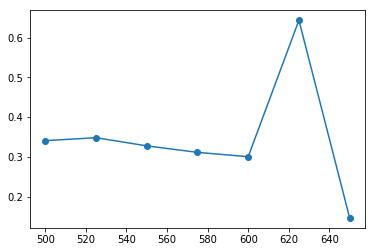

In [115]:
plt.plot(mat[:,0],mat[:,3],'-o')

idx = 0
print(directory)
print('[{},{}]'.format(np.mean(mat[idx:,3]),np.std(mat[idx:,3])))

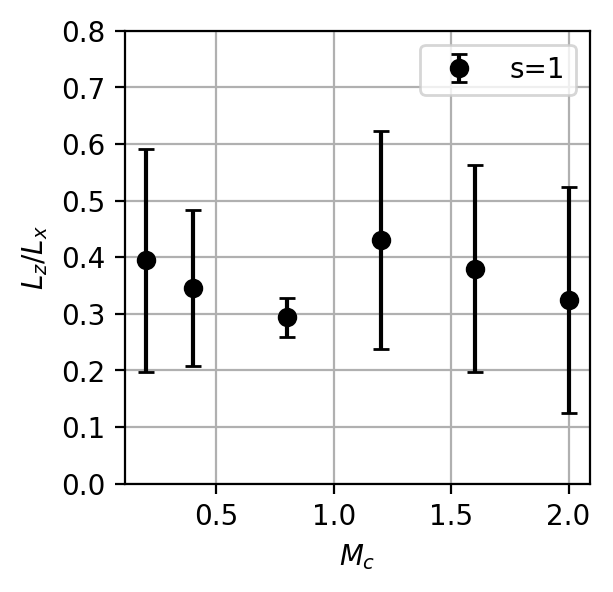

In [118]:
Lvv = { #u"
    0.2: [0.394366488378,0.196354103904],
    0.4: [0.345458934995,0.137573580929],
    0.8: [0.293725036757,0.0348209865744],
    1.2: [0.429952449617,0.192878600611],
    1.6: [0.379943211872,0.182009615401],
    2.0: [0.324561849201,0.199734223216]
}
# Lvv = { #v"
#     0.2: [0.615723555051,0.0892884155246],
#     0.4: [0.508390639196,0.0594043020394],
#     0.8: [0.586645851869,0.0810710415954],
#     1.2: [0.618304063829,0.0405889732682],
#     1.6: [0.624280593675,0.0261136570793],
#     2.0: [0.579075967095,0.0390412054867]
# }

Lvv_rr7 = {
    0.2: [0.219559451514, 0.00992147938793],
    0.8: [0.135476684041, 0.00360524761355],
    2.0: [0.0991706552096, 0.00502552057177] }

Lvv_rr_7 = {
    0.2: [0.221562469353, 0.00338271367857],
    0.8: [0.143466644374, 0.00544143962459],
    2.0: [0.0765113975654, 0.00175996172299]}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5 + np.std([v1,v2])
        new[key] = [(v1+v2)/2., err]
    return new

# rr = merge_dicts(Lvv_rr7,Lvv_rr_7)

fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)

plt.legend()
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L_z/L_x$')
# plt.ylim([0.3,0.8])
plt.ylim([0.0,0.8])
plt.savefig('/home/kmatsuno/ShearLayer_img/lscale_xz.png',dpi=200, bbox_inches='tight')